# Table of Contents
<p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev2"><a href="##Task-1.1.-Guinea"><span class="toc-item-num">Task 1.1.&nbsp;&nbsp;</span>Guinea</a></div>
 <div class="lev1"><a href="#Task-1.2.-Liberia"><span class="toc-item-num">Task 1.2.&nbsp;&nbsp;</span>Liberia</a></div>
 <div class="lev1"><a href="#Task-1.3.-Sierra-Leione"><span class="toc-item-num">Task 1.3.&nbsp;&nbsp;</span>Sierra Leone</a></div>
 <div class="lev1"><a href="#Task-1.4.-Conclusion"><span class="toc-item-num">Task 1.4.&nbsp;&nbsp;</span>Conclusion</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-2.1-Importing-the-files"><span class="toc-item-num">Task 2.1.&nbsp;&nbsp;</span>Importing the files</a></div>
 <div class="lev1"><a href="#Task-2.2-First-four-merges"><span class="toc-item-num">Task 2.2.&nbsp;&nbsp;</span>First four merges</a></div>
 <div class="lev1"><a href="#Task-2.3-combine-the-four-dataframes-into-one"><span class="toc-item-num">Task 2.3.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-2.4-Final-comments"><span class="toc-item-num">Task 2.4.&nbsp;&nbsp;</span>Final comments</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div>
 <div class="lev1"><a href="#Task-3.1.-Question-1:"><span class="toc-item-num">Task 3.1.&nbsp;&nbsp;</span>Question 1</a></div>
 <div class="lev1"><a href="#Task-3.2.-Question-2:"><span class="toc-item-num">Task 3.2.&nbsp;&nbsp;</span>Question 2</a></div>
 <div class="lev1"><a href="#Task-3.3.-Question-3:"><span class="toc-item-num">Task 3.3.&nbsp;&nbsp;</span>Question 3</a></div>
 <div class="lev1"><a href="#Task-3.4.-Question-4:"><span class="toc-item-num">Task 3.4.&nbsp;&nbsp;</span>Question 4</a></div>
 <div class="lev1"><a href="#Task-3.5.-Question-5:"><span class="toc-item-num">Task 3.5.&nbsp;&nbsp;</span>Question 5</a></div>
 <div class="lev1"><a href="#Task-3.6.-Question-6:"><span class="toc-item-num">Task 3.6.&nbsp;&nbsp;</span>Question 6</a></div></p>

First of all, the main libraries useful for this homework are imported:

In [5]:
# Import libraries
import pandas as pd 
import numpy as np 
import glob 
pd.options.mode.chained_assignment = None 
from datetime import datetime, date, time
from dateutil.parser import parse

In [6]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

# Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

Our goal in this first task is to obtain a unique dataframe with the **daily average per month** of new cases and deaths for the three different countries. Our approach is to analyse the three countries separetly and then merge them in an unique `Dataframe`.

For each country, there are different reports in `.csv` format. We are going to use some functions of the `Glob` library in order to merge all the daily reports in a three `Dataframe`'s, one for each country. Then, `Pandas` library will be used in order to structure all the data and then analyse it. Other libraries as `Numpy` or `Datetime` will be also used.

## Task 1.1. Guinea

We first merge all the '.csv' files found in the `guinea_data` folder into one one single `DataFrame`.

In [7]:
# Import Guinea data in one file
data_folder = DATA_FOLDER+'/ebola/guinea_data/'
allFiles = glob.glob(data_folder + "/*.csv")
print('Number of csv files:',len(allFiles))
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
guinea_df = pd.concat(list_)

# Summerize guinea_df
print('Shape guinea_df:',guinea_df.shape)
print('Columns:', guinea_df.columns)

Number of csv files: 22
Shape guinea_df: (714, 25)
Columns: Index(['Beyla', 'Boffa', 'Conakry', 'Coyah', 'Dabola', 'Dalaba', 'Date',
       'Description', 'Dinguiraye', 'Dubreka', 'Forecariah', 'Gueckedou',
       'Kerouane', 'Kindia', 'Kissidougou', 'Kouroussa', 'Lola', 'Macenta',
       'Mzerekore', 'Nzerekore', 'Pita', 'Siguiri', 'Telimele', 'Totals',
       'Yomou'],
      dtype='object')


In the `guinea_dat` folder, 22 different reports are found. The resulting `DataFrame` has 25 columns and 714 different entries. 

We note that the columns of our interest are `Date`, `Description` and `Total`, as we only look for global daily new cases and deaths for all the country. 

It is assumed that the column `Totals` summarizes correctly all the other regional accounting columns. However, the following, closer look at the data shows that this is not true.


Let's compare the values in the column `Totals` with the values compute manually by summing the values in the other columns of the dataset:

In [27]:
guinea_df.head()

,Date,Description,Totals
0,2014-10-01,New cases of suspects,28
1,2014-10-01,New cases of probables,0
2,2014-10-01,New cases of confirmed,6
3,2014-10-01,Total new cases registered so far,34
4,2014-10-01,Total cases of suspects,45


In [163]:
manual_tot = guinea_df[['Beyla', 'Boffa', 'Conakry', 'Coyah', 'Dabola', 'Dalaba',
           'Dinguiraye', 'Dubreka', 'Forecariah', 'Gueckedou',
           'Kerouane', 'Kindia', 'Kissidougou', 'Kouroussa', 'Lola', 'Macenta',
           'Mzerekore', 'Nzerekore', 'Pita', 'Siguiri', 'Telimele', 
           'Yomou']].reset_index().loc[0:20].fillna(value=0).apply(pd.to_numeric).astype(int).sum(axis=1)

# Change to numeric format the Totals column
provided_tot = guinea_df['Totals'].reset_index(drop=True).loc[0:20].apply(pd.to_numeric).astype(int)

# Add index name
manual_tot.name='total values computed manually'
provided_tot.name='total values provided'

# Show a comparison table
pd.DataFrame(data=[provided_tot, manual_tot])

KeyError: "['Beyla' 'Boffa' 'Conakry' 'Coyah' 'Dabola' 'Dalaba' 'Dinguiraye' 'Dubreka'\n 'Forecariah' 'Gueckedou' 'Kerouane' 'Kindia' 'Kissidougou' 'Kouroussa'\n 'Lola' 'Macenta' 'Mzerekore' 'Nzerekore' 'Pita' 'Siguiri' 'Telimele'\n 'Yomou'] not in index"

The difference the values shown in the `DataFrame` above are 'very' close for the purpose of this work. _The values provided in the column 'Totals' will then be used for the following reasons:_
* The values obtained in the two different ways are 'close' for the purpose of this work.
* It is impossible to infer which data is correct and which is not, so the simpler approach would be preferable.
* The dataframe is very dirty: computing the total manually would imply a lot of work to clean the dataset.
* The _total values provided_ seems to be always less that _total values computed manually_. This seems not to be a casualty: probably the 'Total' data provided in the reports has been revised in order to be less alarmistic and more cautious. It could be a good idea to adopt the same approach. 

Let's then select the columns of our interest:

In [166]:
# Select and switch the column order by name 
guinea_df = guinea_df[['Date','Description', 'Totals']]

print(guinea_df.head(5))

         Date                        Description Totals
0  2014-10-01              New cases of suspects     28
1  2014-10-01             New cases of probables      0
2  2014-10-01             New cases of confirmed      6
3  2014-10-01  Total new cases registered so far     34
4  2014-10-01            Total cases of suspects     45


From the `DataFrame` above, we identify different classes for **new cases and new deaths** in `Description` column. Let's identify and select the `Description`'s of our interest: 

In [110]:
# Identify all the Description categories
guinea_df.Description.value_counts()[0:10]

Number of contacts to follow today                 22
New cases of confirmed                             22
Total deaths of probables                          22
Total deaths (confirmed + probables + suspects)    22
Cumulative (confirmed + probable + suspects)       22
Total cases of confirmed                           22
Total deaths of confirmed                          22
New cases of probables                             22
Total deaths of suspects                           22
Total cases of probables                           22
Name: Description, dtype: int64

The following categories in `Description` are chosen to be analysed:

* `Total new cases registered so far`
* `New death registered today`
* `New death registered`

As we can see, the last two categories refer to the same kind of data (New deaths). So we need to rename one of both. 

In addition, we are going to check the shape of both `DataFrame` to verify that we are not missing any information on the renaming operation.

In [29]:
# Concatenate the Description categories of our interest
guinea_df_new = pd.concat([guinea_df[guinea_df.Description == 'Total new cases registered so far'],
                           guinea_df[guinea_df.Description  == 'New deaths registered'],
                           guinea_df[guinea_df.Description  == 'New deaths registered today']])

# Aggregate New deaths in only one category
guinea_df_new.Description = guinea_df_new.Description.replace('New deaths registered today', 'New deaths registered')

# Verify that the number of rows is 22*2
print('Shape guinea_df_new:', guinea_df_new.shape)

Shape guinea_df_new: (44, 3)


It is verified that there is 22 datapoints for each category (new cases/new deaths) which corresponds to the 22 guinea reports. 

Once the rows with all the relevant information for our analysis have been concatenated, we start to clean the data :

In [30]:
# Fill missing values with a 0 
if guinea_df_new.Totals.isnull().any():
    guinea_df_new = guinea_df_new.fillna(value=0)

# Get the data type for each column
guinea_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 3 to 8
Data columns (total 3 columns):
Date           44 non-null object
Description    44 non-null object
Totals         44 non-null object
dtypes: object(3)
memory usage: 1.4+ KB


The datatype for all the columns is `object`. Let's transform the `Date` column in datetime format and the `Totals` column to numeric(`int`). In addition, a `Month` column will be added for the ease of analysing the new cases and deaths per month.

In [113]:
# Change to date format the Date column
guinea_df_new.Date = guinea_df_new['Date'].apply(lambda d: pd.to_datetime(d))
guinea_df_new['Month'] = [date.month for date in guinea_df_new.Date]
guinea_df_new = guinea_df_new[['Date','Month', 'Description', 'Totals']]

# Change to numeric the Totals
guinea_df_new['Totals'] = guinea_df_new['Totals'].apply(pd.to_numeric).astype(int)

# Verify the new columns dtypes
guinea_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 3 to 8
Data columns (total 4 columns):
Date           44 non-null datetime64[ns]
Month          44 non-null int64
Description    44 non-null object
Totals         44 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.7+ KB


In order to compute the `monthly daily average`, we need to identify the first report date and the last report date.

In [114]:
print(guinea_df_new['Month'].value_counts())
print('First report date:',np.min(guinea_df_new.Date))
print('Last report date:', np.max(guinea_df_new.Date))

9     32
8     10
10     2
Name: Month, dtype: int64
First report date: 2014-08-04 00:00:00
Last report date: 2014-10-01 00:00:00


We assume:
* The only report from October is accounting for the month of September new cases and deaths.
* The first report of August is accounting for the new cases and deaths of the three first days of the month, and none of the previous month.

For this reason, we modify the last report month from October to Semptember (10 to 9). We don't care about modifying the day, since the final goal is to aggregate the data per month.

In [115]:
# Change the last report month
guinea_df_new.Month = guinea_df_new['Month'].replace(10, 9)

# New cases
new_cases = guinea_df_new[guinea_df_new.Description == 'Total new cases registered so far']
new_cases_grouped = new_cases.groupby('Month').agg(np.sum)/31
new_cases_grouped.rename(columns={'Totals': 'avg_new_cases'}, inplace=True)

# New deaths
new_deaths = guinea_df_new[guinea_df_new.Description == 'New deaths registered']
new_deaths_grouped = new_deaths.groupby('Month').agg(np.sum)/30
new_deaths_grouped.rename(columns={'Totals': 'avg_new_deaths'}, inplace=True)

# Concatenate
guinea_conc = pd.concat([new_cases_grouped, new_deaths_grouped], axis=1)
guinea_conc['Country'] = 'Guinea'

# Set precision of the DataFrame
pd.set_option('precision', 2)

# Show the guinea results
guinea_conc

,avg_new_cases,avg_new_deaths,Country
Month,,,
8,4.16,0.57,Guinea
9,11.23,2.40,Guinea


## Task 1.2. Liberia 

We follow the same procedure done for Guinea, in this case for Liberia:

In [34]:
# Import Liberia data in one file
data_folder =DATA_FOLDER+'/ebola/liberia_data/'
allFiles = glob.glob(data_folder + "/*.csv")
print('Number of csv files:',len(allFiles))
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
liberia_df = pd.concat(list_)

# Summerize liberia_df
print('Shape guinea_df:',liberia_df.shape)
print('Columns:', liberia_df.columns)

Number of csv files: 100
Shape guinea_df: (3152, 19)
Columns: Index(['Bomi County', 'Bong County', 'Date', 'Gbarpolu County', 'Grand Bassa',
       'Grand Cape Mount', 'Grand Gedeh', 'Grand Kru', 'Lofa County',
       'Margibi County', 'Maryland County', 'Montserrado County', 'National',
       'Nimba County', 'River Gee County', 'RiverCess County', 'Sinoe County',
       'Unnamed: 18', 'Variable'],
      dtype='object')


The following column categories are identified of our interest: `Date`, `Variable`, `National` 

We still keep the assumption that the National columns well accounts for all the new cases and deaths for each region.

In [35]:
# Columns selection and order switching
liberia_df = liberia_df[['Date','Variable', 'National']]
liberia_df.head(5)

,Date,Variable,National
0,09/26/2014,Specimens collected,NaN
1,09/26/2014,Specimens pending for testing,NaN
2,09/26/2014,Total specimens tested,NaN
3,09/26/2014,Newly reported deaths,64.0
4,09/26/2014,Total death/s in confirmed cases,882.0


In order to classify the new cases and new deaths, we need to know the different categories in Variables:

In [36]:
# Identify the different categories in Variable
liberia_df.Variable.value_counts()

Cumulative cases among HCW                                          101
Total death/s in confirmed cases                                    101
Total death/s in probable cases                                     101
Cumulative deaths among HCW                                         101
Total death/s in suspected cases                                    101
Contacts seen                                                       100
Newly Reported Cases in HCW                                         100
New case/s (confirmed)                                              100
Contacts lost to follow-up                                          100
Total confirmed cases                                               100
Total suspected cases                                               100
Newly reported contacts                                             100
Newly Reported deaths in HCW                                        100
Total contacts listed                                           

We are going to select the following:

* `Newly reported deaths`
* `New case/s (confirmed)`
* `New Case/s (Suspected)`
* `New Case/s (Probable)`

Since this choice seemed the most similar to the one previously did in the Guinea case (make the different countries comparable).

Let's concatenate this categories:

In [129]:
liberia_df.head()
liberia_df.Variable.value_counts().head()

Cumulative cases among HCW          101
Total death/s in confirmed cases    101
Total death/s in probable cases     101
Cumulative deaths among HCW         101
Total death/s in suspected cases    101
Name: Variable, dtype: int64

In [37]:
liberia_df_new = pd.concat([liberia_df[liberia_df.Variable == 'New Case/s (Probable)'],
                            liberia_df[liberia_df.Variable  == 'New Case/s (Suspected)'],
                            liberia_df[liberia_df.Variable  == 'New case/s (confirmed)'],
                            liberia_df[liberia_df.Variable  == 'Newly reported deaths']])

print('Shape liberia_df_new:', liberia_df_new.shape)

Shape liberia_df_new: (400, 3)


The shape of the new concatenated dataframe is computed to verfify that there are 100 data entries per category as there are the same number evola reports. We are able to start with the data cleaning and analysis:

In [38]:
# Fill nan values with a 0 if there is any value null
if liberia_df_new.National.isnull().any():
    liberia_df_new = liberia_df_new.fillna(value=0)

# Get the data type of each column
liberia_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 24 to 3
Data columns (total 3 columns):
Date        400 non-null object
Variable    400 non-null object
National    400 non-null float64
dtypes: float64(1), object(2)
memory usage: 12.5+ KB


As we did before, we modify the datatypes for each category and we create the `Month` column.

In [130]:
# Change to date format the Date column
liberia_df_new.Date = liberia_df_new.Date.apply(lambda d: pd.to_datetime(d))
liberia_df_new['Month'] = [date.month for date in liberia_df_new.Date] # Create a new column 'Month'
liberia_df_new = liberia_df_new[['Date','Month', 'Variable', 'National']]

In [136]:
liberia_df_new['National'].apply(pd.to_numeric).astype(int).value_counts().head()


0    71
2    25
1    19
4    16
5    14
Name: National, dtype: int64

In [39]:
# Change to numeric the Totals
liberia_df_new['National'] = liberia_df_new['National'].apply(pd.to_numeric).astype(int)

# Verify that the columns dtypes have been modified
liberia_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 24 to 3
Data columns (total 4 columns):
Date        400 non-null datetime64[ns]
Month       400 non-null int64
Variable    400 non-null object
National    400 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 15.6+ KB


Let's analyse the number of reports per months and the first and final report date's:

In [138]:
print(liberia_df_new.Month.value_counts()/4)
print('First date of June:',np.min(liberia_df_new.Date))
print('Last date of December:', np.max(liberia_df_new.Date))

10    25.0
9     24.0
11    15.0
7     11.0
12     9.0
8      9.0
6      7.0
Name: Month, dtype: float64
First date of June: 2014-06-16 00:00:00
Last date of December: 2014-12-09 00:00:00


In this case, we will analyse the new cases and new deaths separately because we need to aggregate the three categories meaning `new case`.

In addition, it is identified an error on the number of new cases and deaths in December. For this reason, we drop the values for December. A further analysis could be to identify what is the exact error (apparently it has been used the cumulative value in the New column, so that we could compute the difference between preceding dates). 

Please note that we first rename as average and then we compute the average.


In [41]:
# New cases
new_cases_l = pd.concat([liberia_df_new[liberia_df_new.Variable == 'New Case/s (Probable)'],
                         liberia_df_new[liberia_df_new.Variable  == 'New Case/s (Suspected)'],
                         liberia_df_new[liberia_df_new.Variable  == 'New case/s (confirmed)']])

new_cases_l_grouped = new_cases_l.groupby('Month').agg(np.sum) # Aggegate per month
new_cases_l_grouped = new_cases_l_grouped.rename(columns={'National': 'avg_new_cases'}) 

# New deaths
new_deaths_l = liberia_df_new[liberia_df_new.Variable == 'Newly reported deaths']
new_deaths_l_grouped = new_deaths_l.groupby('Month').agg(np.sum)
new_deaths_l_grouped = new_deaths_l_grouped.rename(columns={'National': 'avg_new_deaths'})
liberia_conc = pd.concat([new_cases_l_grouped, new_deaths_l_grouped], axis=1)
liberia_conc.drop(12, inplace=True) # Drop December data

# Compute the daily average
days_per_month = [15, 31, 31, 30, 31, 30]  
pd.set_option('precision', 2)
liberia_conc.avg_new_cases = liberia_conc.avg_new_cases/days_per_month
liberia_conc.avg_new_deaths = liberia_conc.avg_new_deaths/days_per_month

# Add Country column
liberia_conc['Country'] = 'Liberia'

# Show the results
liberia_conc

,avg_new_cases,avg_new_deaths,Country
Month,,,
6,2.67,0.93,Liberia
7,3.03,1.52,Liberia
8,10.81,6.74,Liberia
9,51.07,28.83,Liberia
10,36.74,22.61,Liberia
11,13.23,6.73,Liberia


## Task 1.3. Sierra Leone


Again, we follow the same procedure for Sierra Leone.

In [42]:
# Import Guinea data in one file
data_folder =DATA_FOLDER+'/ebola/sl_data/'
allFiles = glob.glob(data_folder + "/*.csv")
print('Number of csv files:',len(allFiles))
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
sl_df = pd.concat(list_)

# Summerize sl_df
print('Shape sl_df:',sl_df.shape)
print('Columns:', sl_df.columns)

Number of csv files: 103
Shape sl_df: (3262, 27)
Columns: Index(['34 Military Hospital', 'Bo', 'Bo EMC', 'Bombali', 'Bonthe',
       'Hastings-F/Town', 'Kailahun', 'Kambia', 'Kenema', 'Kenema (IFRC)',
       'Kenema (KGH)', 'Koinadugu', 'Kono', 'Moyamba', 'National',
       'Police training School', 'Police traning School', 'Port Loko',
       'Pujehun', 'Tonkolili', 'Unnamed: 18', 'Western area',
       'Western area combined', 'Western area rural', 'Western area urban',
       'date', 'variable'],
      dtype='object')


We identify the columns of our interest: `date`, `variable` and `National`

In [43]:
# Selection and order switching
sl_df = sl_df[['date','variable', 'National']]

In order to classify the new cases and new deaths, we need to know the different categories in `variables`:

In [139]:
# Identify the different categories in Variable
sl_df.variable.value_counts().head()

cum_noncase           103
etc_new_discharges    103
cfr                   103
contacts_ill          103
death_confirmed       103
Name: variable, dtype: int64

It has been identified the following categories in `variables` for our interest:
* `new_confirmed`
* `new_probable`
* `new_suspected`
* `death_confirmed`

We assume that when there is missing values in `Nationals`, it means that it is equal to 0. 

Let's analyse first `new cases` categories:

In [45]:
# New cases categories
sl_df_new = pd.concat([sl_df[sl_df.variable == 'new_confirmed'],
                         sl_df[sl_df.variable  == 'new_probable'],
                         sl_df[sl_df.variable  == 'new_suspected']])

# Fill the missing values in Nationals with 0 
sl_df_new = sl_df_new.fillna(value=0)

# Get the dypes
sl_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 4 to 2
Data columns (total 3 columns):
date        309 non-null object
variable    309 non-null object
National    309 non-null object
dtypes: object(3)
memory usage: 9.7+ KB


Let's change the format of the columns:

In [46]:
# Change to date format the Date column
sl_df_new.date = sl_df_new.date.apply(lambda d: pd.to_datetime(d))
sl_df_new['Month'] = [date.month for date in sl_df_new.date] 
sl_df_new = sl_df_new[['date','Month', 'variable', 'National']]
sl_df_new.set_index('date', inplace=True)

# Change to numeric the Totals
sl_df_new['National'] = sl_df_new['National'].apply(pd.to_numeric).astype(int)

In [47]:
# Identify the reports dates
print(sl_df_new.Month.value_counts()/3)
print('First date of August:',np.min(sl_df_new.index))
print('Last date of December:', np.max(sl_df_new.index))

9     29.0
10    28.0
11    21.0
8     20.0
12     5.0
Name: Month, dtype: float64
First date of August: 2014-08-12 00:00:00
Last date of December: 2014-12-13 00:00:00


In [48]:
# Aggregate the per month to get the total new cases per month
sl_df_new = sl_df_new.groupby('Month').agg(np.sum)

days = [31-12, 30, 31, 30, 13]
sl_df_new['National']=sl_df_new['National']/days
sl_df_new.rename(columns={'National': 'avg_new_cases'}, inplace=True)
sl_df_new

,avg_new_cases
Month,
8,26.47
9,39.33
10,64.06
11,52.67
12,15.77


Let's analyse the new deaths. We identify that the category of `new_cases` is a cumulative value. In order to compute the new deaths we are going to compute the difference between two preceding reports:

In [49]:
# Select the new_deaths category
sl_temp = sl_df[sl_df.variable == 'death_confirmed'] 

# Fill the missing values by backfill to compute the difference of the cumulative number of deaths to know the new deaths 
sl_temp = sl_temp.fillna(method='bfill')
sl_temp = sl_temp.fillna('1708')

# Change the data type of Nationals
sl_temp['National'] = sl_temp['National'].apply(pd.to_numeric).astype(int)  # Change to numeric the Totals

# Compute the new cases value by doing the difference
sl_temp.National = sl_temp.National.diff().fillna(0)

# Change to date format the Date column
sl_temp.date = sl_temp.date.apply(lambda d: pd.to_datetime(d))
sl_temp['Month'] = [date.month for date in sl_temp.date] # Create a new column 'Month'
sl_temp = sl_temp[['date','Month', 'variable', 'National']]
sl_temp.set_index('date', inplace=True)

# Compute the new deaths average per month
sl_temp = sl_temp.groupby('Month').sum()
sl_temp.National = sl_temp.National/days
sl_temp.rename(columns={'National':'avg_new_deaths'}, inplace=True)

# Concatenate the new cases and new deaths
sl_conc = pd.concat([sl_df_new, sl_temp], axis=1)

# Add country column
sl_conc['Country'] = 'Sierra Leone'

# Show results
sl_conc

,avg_new_cases,avg_new_deaths,Country
Month,,,
8,26.47,-468.16,Sierra Leone
9,39.33,-106.87,Sierra Leone
10,64.06,-11.19,Sierra Leone
11,52.67,312.47,Sierra Leone
12,15.77,236.23,Sierra Leone


## Task 1.4. Conclusion

In order to compare the new cases and new deaths we are coing to concatenate the results for the three countries

In [50]:
ebola = pd.concat([guinea_conc, liberia_conc, sl_conc])

# Create a copy to plot the results after
ebolaf = ebola.copy()

ebola = ebola.reset_index()
ebola.set_index(['Month', 'Country'], inplace=True)
ebola.sort_index(inplace=True)

# Adapt the dataframe to be able to plot
ebolaf.reset_index(drop=False,inplace=True)



Let's visualize the results in two Barplot: one for the new cases and one for the new deaths:

Populating the interactive namespace from numpy and matplotlib


/home/zampieri/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


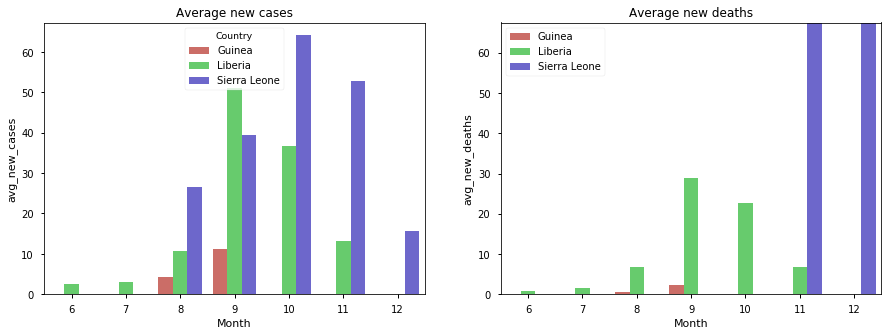

In [51]:
# Import ploting libraries
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

# Seaborn parameters
sns.set_palette('Reds')
sns.set_context("notebook") # possible values are paper, notebook, talk, and poster

# Initialise the subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Average new cases')
ax2.set_title('Average new deaths')

# New cases plot
sns.factorplot(x="Month",y='avg_new_cases',hue='Country', data=ebolaf, kind="bar",\
                   palette='hls',legend=True, margin_titles=True,ax=ax1)
plt.close()

# New deaths plot
sns.factorplot(x="Month",y='avg_new_deaths',hue='Country', data=ebolaf, kind="bar",\
                   palette='hls',legend=True, margin_titles=True,ax=ax2)

plt.close()
plt.ylim(0,67.5)
plt.legend(loc='upper left')
plt.legend(loc='upper left')

Thanks to this visualisation, we can draw some conclusions: 
* As it is logic, there are more daily new cases than deaths in average.
* Sierra Leone is the country with more daily new cases. However, there are more newly deaths in Liberia. This fact is maybe due to the level of healthcare of both countries.
* In Sierra Leone, we identify an increase of new cases during October and Novemeber. However, there is an stable number of daily deaths during the same months (around 14).
* The daily new deaths in Liberia hasa decreasing trend.
* Guinea has much less deaths than the other two countries.



# Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

## Task 2.1 Importing the files

The files from MID1.xls to MID9.xls have been opened in Excel to have a look directly on the data, to be sure about the number of spreadsheets contained in every file and not to forget to import any data. Once that it's been verified that every .xls file has only one sheet, the first 9 .xls files have been imported into the following 9 different dataframes.
The name 'mb1' stands for 'microbiome 1', 'mb2' stands for 'microbiome 2', and so on. 

In [52]:
# Importing all the files from excel
mb1 = pd.read_excel(DATA_FOLDER+'/microbiome/MID1.xls', 'Sheet 1', index_col=0, header=None)
mb2 = pd.read_excel(DATA_FOLDER+'/microbiome/MID2.xls', 'Sheet 1', index_col=0, header=None)
mb3 = pd.read_excel(DATA_FOLDER+'/microbiome/MID3.xls', 'Sheet 1', index_col=0, header=None)
mb4 = pd.read_excel(DATA_FOLDER+'/microbiome/MID4.xls', 'Sheet 1', index_col=0, header=None)
mb5 = pd.read_excel(DATA_FOLDER+'/microbiome/MID5.xls', 'Sheet 1', index_col=0, header=None)
mb6 = pd.read_excel(DATA_FOLDER+'/microbiome/MID6.xls', 'Sheet 1', index_col=0, header=None)
mb7 = pd.read_excel(DATA_FOLDER+'/microbiome/MID7.xls', 'Sheet 1', index_col=0, header=None)
mb8 = pd.read_excel(DATA_FOLDER+'/microbiome/MID8.xls', 'Sheet 1', index_col=0, header=None)
mb9 = pd.read_excel(DATA_FOLDER+'/microbiome/MID9.xls', 'Sheet 1', index_col=0, header=None)

### Taking a look on the datasets

From the previous look directly in Excel, all the dataframes looked very simple, with only one column for the name of the bacteria and one column for the corresponding value, probably recorded in some experiment. Here the head of the first dataframe is displayed anyway in order to:
* check that the data have been successfully imported
* provide ourself with a visual image of the dataset as a help for correctly handle this dataset

In [53]:
mb1.head()

,1
0,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",2
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",3
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum",3
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",7


It can be observed that Pandas already recognised the first column as index, and put the recorded value as unique value of the dataframe.
Now the 10th dataframe 'metadata.xls' is loaded to provide us information on the values of the dataframes mb1-mb9:

In [54]:
names = pd.read_excel(DATA_FOLDER+'/microbiome/metadata.xls', 'Sheet1', na_values=['NA'])
names

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,NaN
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


Setting the 'BARCODE' column as index we obtain:

In [55]:
names.set_index('BARCODE', inplace=True)
names

,GROUP,SAMPLE
BARCODE,,
MID1,EXTRACTION CONTROL,NaN
MID2,NEC 1,tissue
MID3,Control 1,tissue
MID4,NEC 2,tissue
MID5,Control 2,tissue
MID6,NEC 1,stool
MID7,Control 1,stool
MID8,NEC 2,stool
MID9,Control 2,stool


Let's now see in details the infos provided in the different spreadsheets:

The following things can be noticed:
* the dataframes have very different sizes (from 99 to 385),
* all the dataframes have really high std dev, with a lot of low values and a few really high ones

### Comment on the metadata.xls and on what we  understood of the dataset
From the metadata.xls file, the following meaning of the files `MB1-MB9` has been understood.
* For each bacteria, only one value for the field `'extraction control'` has been recorded.
* For each bacteria, the values of the fields 'NEC' and 'Control' have been recorded four times each (`'NEC 1'`, `'NEC 2'`, `'Control 1'`, `'Control 2'`) on two different `'samples'={'tissue', 'stool'}` and in two different `contexts={1, 2}`. 

### Final goal

To keep track of the `'NEC'` and `'Control'` values, it seems then logical merge the _eigth dataframes mb2-mb9_ into one single dataset with the following carachteristcs:
* a three-level index with the following levels: `['bacteria name', 'sample', 'context']`
* with the following columns: `['NEC', 'Control','extraction control']`


## Task 2.2 First four merges

Let's then procede by renaming the index and the value of each dataframe in a logical way

In [57]:
for mb in [mb1,mb2, mb3, mb4, mb5, mb6, mb7, mb8, mb9]:
    mb.columns=['count']
    mb.index.name='bacteria'

Now, let's do _4 merges_ of the following couples of dataframes:

* `mb2` with `mb3`
* `mb4` with `mb5`
* `mb6` with `mb7`
* `mb8` with `mb9`

and store the results in a list of resulting dataframes called `_4df`

Recall that:
* `mb2, mb3` contains respectively the value of `'NEC', 'Control'` for `sample=tissue, context=1`
* `mb4, mb5` contains respectively the value of `'NEC', 'Control'` for `sample=tissue, context=2`
* `mb6, mb7` contains respectively the value of `'NEC', 'Control'` for `sample=stool, context=1`
* `mb8, mb9` contains respectively the value of `'NEC', 'Control'` for `sample=stool, context=2`

The following cell provides a bit cumbersome but short way to do so. The following aspects of the code should be noted:
* `pd.concat()` has been used to concatenate the colums of `'NEC'` and `'Control'` values, since it creates a dataframe with the _union_ of the indices of the two datasets, filling missing values with `NaN`
* two columns have been added to register the `sample` and the `context` of the data of the new dataframes
* A three-level index `['bacteria', 'sample', 'context']` has been created

In [58]:
samples = ['tissue']*2+['stool']*2
_4df=[1,2,3,4]

for i,[M1, M2] in enumerate(zip([mb2, mb4, mb6, mb8],[mb3, mb5, mb7, mb9])):
    _4df[i] = pd.concat( [ M1['count'].rename('NEC'),
                           M2['count'].rename('Control')], axis=1)
    _4df[i] ['sample'] = samples[i]
    _4df[i] ['context']=(i%2)+1
    _4df[i].index.name='bacteria'
    _4df[i]=_4df[i][['sample','context','NEC','Control']]
    _4df[i].set_index(['sample','context'], append=True, inplace=True)

Let's show the results to have a better understanding of what has been done:

## Task 2.3 combine the four dataframes into one
Now, it will be sufficient to _combine_ these datasets to have the desired one. 
Note the use of `combine_first()` so that the result index columns will be the union of the respective indexes and columns of the two arguments of the command.

In [141]:
tissue = _4df[0].combine_first(_4df[1])
stool = _4df[2].combine_first(_4df[3])
tissue_and_stool = stool.combine_first(tissue)
print('the index of the following dataframe is unique?', tissue_and_stool.index.is_unique)
#print('\n\n', tissue_and_stool.describe())
tissue_and_stool.head(5)


the index of the following dataframe is unique? True


NEC  \
bacteria                                           sample context         
Archaea "Crenarchaeota" Thermoprotei Acidilobal... tissue 1         2.0   
                                                          2         NaN   
Archaea "Crenarchaeota" Thermoprotei Acidilobal... stool  1         NaN   
                                                          2         NaN   
                                                   tissue 1        14.0   

                                                                   Control  
bacteria                                           sample context           
Archaea "Crenarchaeota" Thermoprotei Acidilobal... tissue 1            1.0  
                                                          2            5.0  
Archaea "Crenarchaeota" Thermoprotei Acidilobal... stool  1            1.0  
                                                          2            1.0  
                                                   tissue 1           15.0

### Finally, add the 'extraction control' value to the dataframe
and also change the name of the newly added column from _'count'_ to _'extraction control'_

In [64]:
tissue_and_stool = tissue_and_stool.join(mb1, how='outer')
tissue_and_stool.rename(columns={'count': 'extraction control'}, inplace=True)

### Fill NaN values
let's now fill `NaN` values with the tag `unknown` as requested

In [142]:
tissue_and_stool.fillna('unknown', inplace=True )
tissue_and_stool.head(3)

NEC  \
bacteria                                           sample context            
Archaea "Crenarchaeota" Thermoprotei Acidilobal... tissue 1              2   
                                                          2        unknown   
Archaea "Crenarchaeota" Thermoprotei Acidilobal... stool  1        unknown   

                                                                  Control  
bacteria                                           sample context          
Archaea "Crenarchaeota" Thermoprotei Acidilobal... tissue 1             1  
                                                          2             5  
Archaea "Crenarchaeota" Thermoprotei Acidilobal... stool  1             1

## Task 2.4 Final comments
Another option could have been creating more levels for the index, one for every catgory in the bacteria name hierarchy ('Life', 'Domain', 'Kingdom', etc. etc.) to let the user access to subsets of the bacterias in a easy way ( for example, all the bacterias in the _Archaea_ family).
However, it has been thought that such a thing would have created a useless complication in handling this dataset, since for different bacterias we don't even have the complete description of its hierarchy. Also, the dataframe that has been created still let a user familiar with the bacteria hierarchy to perform such a query in the following way:

In [143]:
bacterias = tissue_and_stool.index.get_level_values(0)
mask = ['Archaea' in name for name in bacterias]
#tissue_and_stool.loc[mask]

# Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [144]:
# imports and random stuff (edited by us)
%pylab inline
# Website for maps of titanic: https://www.encyclopedia-titanica.org/titanic-deckplans/boat-deck.html
# (as of friday 7 october)

Populating the interactive namespace from numpy and matplotlib


/home/zampieri/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['argmax']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [146]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
from IPython.core.display import HTML
#HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

We take a look to the dataset (here and in excel)

In [147]:
# Import Titanic data 
data_file =DATA_FOLDER +'/titanic.xls'
data = pd.read_excel(data_file)
ori_data = data.copy()
data.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.34,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.55,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Task 3.1. Question 1:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

We start by replacing the nan with values that are neither above the max value, neither below the min values (for example by replacing them either with the max or min value that we already see). 
It is not a clean way to do it but it is fast. We do it in a copy of the dataset. This is just to have a global idea, a more throughfully analysis is done jsut below.

In [148]:
data['cabin'] = data['cabin'].fillna("M") #not the right way, but will enable us to see the max easily
data['embarked'] = data['embarked'].fillna("C") #not the right way, but will enable us to see the max easily

data['boat'] = data['boat'].fillna("1") #not the right way, but will enable us to see the max easily
data['home.dest'] = data['home.dest'].fillna("?z") #not the right way, but will enable us to see the max easily

Now we converted the types to string to use string comparisons:

In [149]:
data['ticket']    = data['ticket'].astype('str')
data['home.dest'] = data['home.dest'].astype('str') 
data['cabin']     = data['cabin'].astype('str') 
data['boat']     = data['boat'].astype('str') 
data['embarked']     = data['embarked'].astype('str') 

Now we extract the types of our objects and find min-max values. We then merged everything together to make it more readable.

In [150]:
description = pd.DataFrame(data.dtypes.copy())
min_data = pd.DataFrame(data.min())
max_data = pd.DataFrame(data.max())

description.columns=['dtype']
min_data.columns=['min_value']
max_data.columns=['max_value']
tot=description.merge(min_data, left_index=True, right_index=True, how='outer')\
                .merge(max_data, left_index=True, right_index=True, how='outer')
pd.concat([description,min_data,max_data],axis=1)

,dtype,min_value,max_value
pclass,int64,1,3
survived,int64,0,1
name,object,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
sex,object,female,male
age,float64,0.17,80
sibsp,int64,0,8
parch,int64,0,9
ticket,object,110152,WE/P 5735
fare,float64,0,5.1e+02
cabin,object,A10,T


This is mainly informative and give meaningfull infos just for categories with numeric values. For the others categories we will do it later.

Where above when there were numbers and character we compared them with the rules of string comparisons.

We extract some more information as the number of nun-null values.

In [151]:
ori_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


## Dataset infos: 

    *. There are 14 different categaories: 
        - pclass:   the passenger class $ \in $ {1,2,3}, no missing data
        - survived: binary value for survaval
        - name:     full name, often in the form: ["surname", "abreviated title" "names"]
        - sex:      gender: male or female
        - age:      Age in years. If decimal value, we consider it was for representing age with months and days ecc.. (usually for examples for babies, in adults it may have been a typo)
        - sibsp:    Number of siblings/spouses aboard
        - parch:    Number of parents/childrens aboard
        - ticket:   Ticket number (containing also characters)
        - fare:     Prices of the ticket in british pounds
        - cabin:    Cabin number of the form "floor cabin-number"
        - embarked: Port in which the passenger has embarked
        - boat:     The safety boat that the passenger took 
        - body:     Body number of dead passenger
        - home.dest:Origin and destination of the passenger
        
    **Before** continuing any further lets eliminate the data in wich we are not interested, i.e.: 
        - boat
        - sibsp. Could have been used to find out how many persons were in each cabins
        - parch. Same remark than for sibsp
        - body
        - fare. May have been used to determine people by cabins
        - name. May have been used to find spouses, children...
        - ticket. May have been used to find out how many persons by cabins
        - home.dest
    
    (consideration: instead of doing multiples dataframes, we could have added columns to the original, to avoid copies)
        

           
    Categories that we kept, indicating if we could transforn them to categorical:
        - pclass (-> categorical)
        - embarked (-> categorical)
        - sex (-> categorical)
        - age (once by decades, once in tyo equally parted categories) (-> categorical for the decades)
        - cabin floors (-> categorical)
        - survived (-> categorical)

### Notes for the titanic:

    - The deck are: A,B,C,D,E,F,G + Boat deck + Orlop Deck + Tank Top. 
     Since there is only one person in T we suspected an error or it could be living in Tank Top... 
     After having seen the chart, it is not the tank top, so we counted it as an error.
    - We assumed F E57 is the cabin E57 of floor F since on the floor F there are subsection named by letters. This may be an error.
    
Now I take again the original data and begin the data wrangling.

In [152]:
originalDf = pd.read_excel(data_file)
myDf = originalDf.copy()
myDf.drop(['name','sibsp','parch','ticket','fare','boat','body','home.dest'],axis=1,inplace=True)
df_dropped_col=myDf.copy()
myDf.head()

,pclass,survived,sex,age,cabin,embarked
0,1,1,female,29.00,B5,S
1,1,1,male,0.92,C22 C26,S
2,1,0,female,2.00,C22 C26,S
3,1,0,male,30.00,C22 C26,S
4,1,0,female,25.00,C22 C26,S


Transform the cabin column into one indicating the floor and adding a column indicating the number of cabin are associated to each passenger. 

Assumption: We haven't checked that each cabin nulber is a valid number for the given floor (it could be done with the map of the titanic for example). We assume that it is.

In [153]:
myDf['cabin'] = myDf['cabin'].astype('str') 

myDf['cabin count']=pd.DataFrame(myDf['cabin'].str.split(" ").apply(len))
myDf.loc[myDf.cabin == "nan", 'cabin count'] = "0"

myDf.cabin = myDf.cabin.transform(lambda x: x[0])
myDf.head()

,pclass,survived,sex,age,cabin,embarked,cabin count
0,1,1,female,29.00,B,S,1
1,1,1,male,0.92,C,S,2
2,1,0,female,2.00,C,S,2
3,1,0,male,30.00,C,S,2
4,1,0,female,25.00,C,S,2


##### Scan for wrong values for pclass:


In [154]:
print(myDf.pclass.value_counts(),'\n\n True is good: ',myDf.pclass.value_counts().sum()==myDf.shape[0])

3    709
1    323
2    277
Name: pclass, dtype: int64 

 True is good:  True


##### Scan for wrong values for survived:

In [155]:
print('False is good news! \n We have: ',any([(myDf['survived'] != 0) & (myDf['survived'] != 1)])) 

False is good news! 
 We have:  False


##### Scan for wrong values for sex:

In [78]:
print(myDf.sex.value_counts(),'\n\n True is good! ',myDf.sex.value_counts().sum()== myDf.shape[0])
# or we could do 
print('Something wrong? ',any([(myDf['sex'] != 'male') & (myDf['sex'] != 'female')])) # if return false, it is OK!

male      843
female    466
Name: sex, dtype: int64 

 True is good!  True
Something wrong?  False


##### Scan for wrong values for age:

We have already seen the range which is reasonable, and we assume that the decimal reprensent the months so they are accepted.

In [79]:
myDf_sortedAge = myDf.copy().sort_values(['age'], ascending=[1])
#print(myDf_sortedAge.age.value_counts(),'\n\n',myDf.age.value_counts().sum())
print('#(nan) = #(non-numeric)?  ',myDf.age.value_counts().sum() == myDf.copy().dropna(subset=['age']).shape[0])
# if true is promted, it means that all non-identified values (by value_count) are NaN!

#(nan) = #(non-numeric)?   True


##### Scan for wrong values for cabin:

In [80]:
print(myDf.cabin.value_counts())

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64


considering T as a typo: he is the only one in T, and it doesn't seems like it is an habitable floor on the map
Instead, we will put him in cabin C since it is the most recurrent! 

In [81]:
myDf.cabin[(myDf['cabin'] == 'T')]='C'
print(myDf.cabin.value_counts())

n    1014
C      95
B      65
D      46
E      41
A      22
F      21
G       5
Name: cabin, dtype: int64


##### Scan for wrong values for embarked:

In [82]:
print(myDf.embarked.value_counts().sum())
myDf["embarked"][(myDf['embarked'] != 'C') & (myDf['embarked'] != 'Q') & (myDf['embarked'] != 'S')] = 'S'
print(myDf.embarked.value_counts().sum() , 'if == ',myDf.shape[0],',it is wonderful!')

1307
1309 if ==  1309 ,it is wonderful!


##### Scan for wrong values for cabin count:

In [83]:
print(myDf['cabin count'].value_counts(),'\n\n',myDf['cabin count'].value_counts().sum())
# the sum should be 1309 and the value taken should make sense to us
result_tmp = 0
for i in range(myDf['cabin count'].value_counts().shape[0]):
    result_tmp += i*myDf['cabin count'].value_counts()[i]
print('occupied found places: ',result_tmp, '  closer to 1309 would be better')

0    1014
1     254
2      26
3      10
4       5
Name: cabin count, dtype: int64 

 1309
occupied found places:  356   closer to 1309 would be better


There are too many persons without a room. Our assumption that all the persons wihtout a room where in reality associated with the multiple rooms of some passengers is then wrong. 
Our new options are:
    - the spouses sleep with their partners 
    - sons sleep with parents (or we could just put families together)
    
Some possibilities:
    - we could check what kind of room they booked... 
        - it could be linked with the different fares of same class tickets
        - check on the plans of the titanic
        
We also checked that the # nan did not change before and after our modification. 
cabins with "F "another cabin" have been considered as conataing two persons in F floor, since F floor has subsections with "neiboorhood" named after another floor. Plus the size allows us to add a person... but we should know more about the dataset to conclude.

In [84]:
print(any([(myDf['cabin count'] != 0) & (myDf['cabin count'] != 1) & (myDf['cabin count'] != 2) & (myDf['cabin count'] != 3)]))

True


#### Set everything as categorical ------------------------------------------------------------------
every thing can be set to cateorical in our case, after some modifications of the code. For age, we are gonna separate the two cases:
    - separation by decades
    - separation by two equal classe
and we will do it just after!


In [85]:
myDf['pclass']      = myDf['pclass'].astype('category')
myDf['survived']    = myDf['survived'].astype('category')
myDf['sex']         = myDf['sex'].astype('category')
myDf['cabin']       = myDf['cabin'].astype('category')
myDf['embarked']    = myDf['embarked'].astype('category')
myDf['cabin count'] = myDf['cabin count'].astype('category')

In [86]:
# for the questions where we will need age in decades
myDf_decades = myDf.copy()
myDf_decades.age = myDf_decades.age.transform(lambda x: 10*floor(x/10))
myDf_decades['age'] = myDf_decades['age'].astype('category')
myDf_decades.head()

,pclass,survived,sex,age,cabin,embarked,cabin count
0,1,1,female,20.0,B,S,1
1,1,1,male,0.0,C,S,2
2,1,0,female,0.0,C,S,2
3,1,0,male,30.0,C,S,2
4,1,0,female,20.0,C,S,2


In [87]:
myDf_equalAge = myDf.copy()
myDf_equalAge = myDf_equalAge.dropna(subset=['age'])


myDf_equalAge.sort_values(by='age',inplace=True)
myDf_equalAge.reset_index(drop=False,inplace=True)
myDf_equalAge.rename(columns={'index' : 'old index'},inplace=True)
myDf_equalAge.reset_index(drop=False,inplace=True)
        
half = myDf_equalAge.shape[0]/2
myDf_equalAge['age'][myDf_equalAge['index'] < half] = 1
myDf_equalAge['age'][myDf_equalAge['index'] >= half] = 2

myDf_equalAge['age'] = myDf_equalAge['age'].astype('category')
myDf_equalAge.head()

,index,old index,pclass,survived,sex,age,cabin,embarked,cabin count
0,0,763,3,1,female,1.0,n,S,0
1,1,747,3,0,male,1.0,n,S,0
2,2,1240,3,1,male,1.0,n,C,0
3,3,427,2,1,male,1.0,n,S,0
4,4,1111,3,0,male,1.0,n,S,0


Now we check if it is equally parted

In [88]:
print(myDf_equalAge['age'][myDf_equalAge['age']==1].shape[0])
print(myDf_equalAge['age'][myDf_equalAge['age']==2].shape[0])
print(myDf_equalAge.shape[0])

523
523
1046


#### end of clean data --------------------------------------------------------------------------

At this point everything is categorical. for cabins 'n' are not to be taken into account, since we will take it into account thanks to the cabin count 8our false assumption, that we keep for simplicity)

### **From here the plots start** 

importing libraries for plotting:

In [89]:
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
sns.set_palette('Reds')
sns.set_context("notebook")

Populating the interactive namespace from numpy and matplotlib


/home/zampieri/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['half']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Task 3.2. Question 2:
Plot histograms for the **travel class**, **embarkation port**, **sex** and **age** attributes. For the latter one, use **discrete decade intervals**.

##### Histogram travel class:

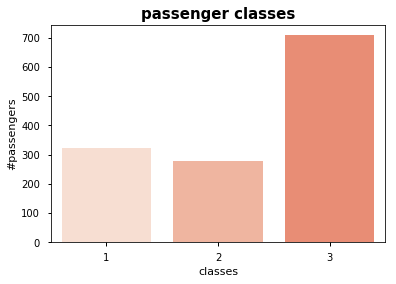

In [90]:
def nice_bar_plot(title, data, n,xlabel,ylabel):
    
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=15, fontweight='bold')
    sns.barplot(data[:n].keys(), data[:n])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    ax.set(xlabel=xlabel, ylabel=ylabel)

tmp = None
tmp = myDf.pclass.value_counts()
nice_bar_plot('passenger classes',tmp,3,'classes','#passengers')

##### histogramm imbarcation port:

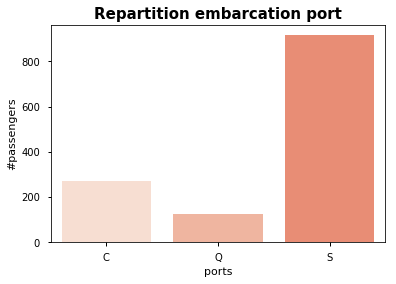

In [91]:
tmp = None
tmp = myDf.embarked.value_counts()
nice_bar_plot('Repartition embarcation port',tmp,3,'ports','#passengers')

##### histogramm gender:

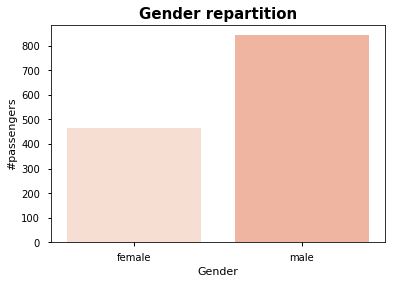

In [92]:
tmp = None
tmp = myDf.sex.value_counts()
nice_bar_plot('Gender repartition',tmp,2,'Gender','#passengers')

##### histogramm age:

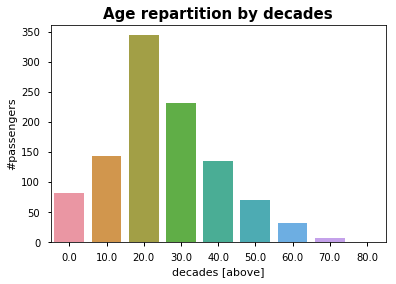

In [93]:
tmp = None
tmp = myDf_decades.age.value_counts()
tmp.sort_index()
nice_bar_plot('Age repartition by decades',tmp,myDf_decades.age.value_counts().shape[0],'decades [above]','#passengers')

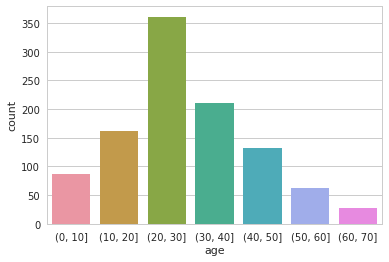

In [162]:
minBin = int((myDf['age'].min()//10)*10)
maxBin = int((myDf['age'].max()//10)*10)
bins = list(range(minBin, maxBin, 10))[1:]

ages = pd.cut(myDf['age'],range(minBin, maxBin,10))
ax = sns.countplot(ages)

where 0.0 means [0,10[ 

## Task 3.3. Question 3: 

Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

##### If we exclude thoses without cabin (most general of our assunmptions)

In [94]:
floor_count = myDf.cabin.groupby(lambda x: myDf.cabin[x]).size()

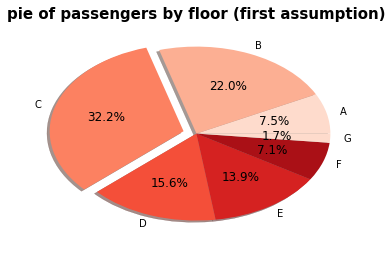

In [95]:
labels = list(floor_count.index)[:-1] # we exclude those without cabins
sizes = list(floor_count)[:-1] # we exclude those without cabins
argmax = np.argmax(sizes)
explode = [0] * len(sizes)
explode[argmax]=0.1
plt.pie(sizes, labels=labels,autopct='%1.1f%%',explode=explode, shadow=True);
plt.title('pie of passengers by floor (first assumption)',fontsize=15, fontweight='bold');

##### if we count the number of cabins (a bit less general assumption)
i.e. if a person has 2 cabins, we will count her/him twice (to implement)

In [96]:
# for cabin count hypothesis: 
tmp = myDf.copy()
tmp['cabin count'] = tmp['cabin count'].astype(int)
grouped = tmp.groupby(by=['cabin'])[['cabin count']].sum()
list(grouped['cabin count'])

[22, 96, 115, 48, 42, 28, 5, 0]

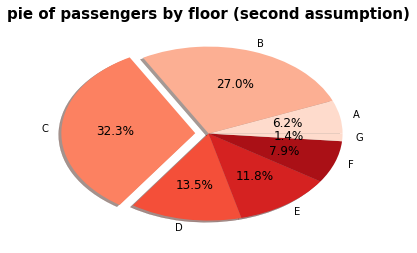

In [97]:
labels = list(grouped.index)[:-1]
sizes = list(grouped['cabin count'])[:-1]
argmax = np.argmax(sizes)
explode = [0] * len(sizes)
explode[argmax]=0.1
plt.pie(sizes, labels=labels,autopct='%1.1f%%',explode=explode, shadow=True);
plt.title('pie of passengers by floor (second assumption)',fontsize=15, fontweight='bold');

## Task 3.4. Question 4:
For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

In [98]:
survived = pd.DataFrame(myDf['pclass'][myDf['survived'] == 1])
total = pd.DataFrame(myDf['pclass'])
grouped_survival = survived.groupby('pclass')
grouped_tot = total.groupby('pclass')
tmp = grouped_survival.size() / grouped_tot.size()

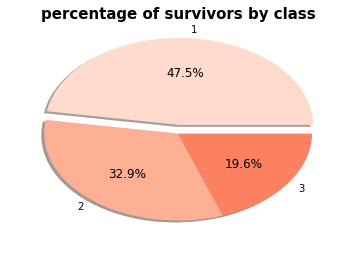

In [99]:
labels = list(tmp.index)
sizes = list(tmp)
argmax = np.argmax(sizes)
explode = [0] * len(sizes)
explode[argmax]=0.1
plt.pie(sizes, labels=labels,autopct='%1.1f%%',explode=explode, shadow=True);
plt.title('percentage of survivors by class',fontsize=15, fontweight='bold');

## Task 3.5. Question 5:
Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

Like the following but with proposrtions:

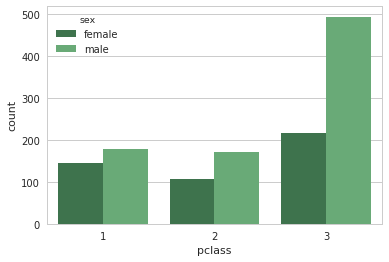

In [100]:
sns.set_style("whitegrid")
ax = sns.countplot(x="pclass", data=myDf,hue="sex", palette="Greens_d");

In [101]:
#for the males
male_survived_byClass = pd.DataFrame(myDf['pclass'][(myDf['survived'] == 1) & (myDf['sex'] == 'male')])
male_byClass = pd.DataFrame(myDf['pclass'][myDf['sex'] == 'male'])

grouped_MS_byClass = male_survived_byClass.groupby('pclass')
grouped_tot_male_byClass = male_byClass.groupby('pclass')

#for the females
female_survived_byClass = pd.DataFrame(myDf['pclass'][(myDf['survived'] == 1) & (myDf['sex'] == 'female')])
female_byClass = pd.DataFrame(myDf['pclass'][myDf['sex'] == 'female'])


grouped_FS_byClass = female_survived_byClass.groupby('pclass')
grouped_tot_female_byClass = female_byClass.groupby('pclass')

proportion_male_byClass = pd.DataFrame(grouped_MS_byClass.size()/grouped_tot_male_byClass.size())
proportion_male_byClass.columns = ['proportions']
proportion_male_byClass['sex'] = 'male'
proportion_male_byClass.reset_index(drop=False,inplace=True)

proportion_female_byClass = pd.DataFrame(grouped_FS_byClass.size()/grouped_tot_female_byClass.size())
proportion_female_byClass.columns = ['proportions']
proportion_female_byClass['sex'] = 'female'
proportion_female_byClass.reset_index(drop=False,inplace=True)

print(proportion_male_byClass )
print(proportion_female_byClass)

survived_bySexClass = proportion_female_byClass.merge(proportion_male_byClass,how='outer')
survived_bySexClass

  pclass  proportions   sex
0      1         0.34  male
1      2         0.15  male
2      3         0.15  male
  pclass  proportions     sex
0      1         0.97  female
1      2         0.89  female
2      3         0.49  female


,pclass,proportions,sex
0,1,0.97,female
1,2,0.89,female
2,3,0.49,female
3,1,0.34,male
4,2,0.15,male
5,3,0.15,male


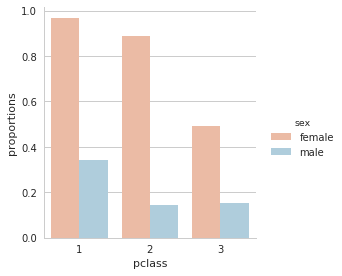

In [102]:
g = sns.factorplot(x="pclass",y='proportions', hue='sex', data=survived_bySexClass, kind="bar",\
                   palette="RdBu",legend=True, margin_titles=True)

The proprotions are w.r.t. themselves, e.g. The first column indicate the proportion of females of first class that survived w.r.t. the total number of females in first class.

Seems like the men have stood up to the sentences "women first"

## Task 3.6. Question 6:    
Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

##### note 
the categories have been done in "myDf_equalAge" variable

In [103]:
tmp1 = myDf_equalAge [(myDf_equalAge['age'] == 1) ].shape[0]
tmp2 = myDf_equalAge [(myDf_equalAge['age'] == 2) ].shape[0]
print('differences of #passengers between the two classes= ',tmp1-tmp2)

differences of #passengers between the two classes=  0


In [104]:
myDf_equalAge.head()

,index,old index,pclass,survived,sex,age,cabin,embarked,cabin count
0,0,763,3,1,female,1.0,n,S,0
1,1,747,3,0,male,1.0,n,S,0
2,2,1240,3,1,male,1.0,n,C,0
3,3,427,2,1,male,1.0,n,S,0
4,4,1111,3,0,male,1.0,n,S,0


Create df with the proportions of survived young (~= less than 36 years old) females by class

In [105]:
#for the females 1
female_survived_byClass_young = pd.DataFrame(myDf_equalAge['pclass']\
                                     [(myDf_equalAge['survived'] == 1) & \
                                      (myDf_equalAge['sex'] == 'female') &\
                                      (myDf_equalAge['age'] == 1)
                                     ])

female_byClass_young = pd.DataFrame(myDf_equalAge['pclass']\
                                     [(myDf_equalAge['sex'] == 'female') &\
                                      (myDf_equalAge['age'] == 1)
                                     ])

grouped_FSY_byClass = female_survived_byClass_young.groupby('pclass') #F female, S survived, Y young
grouped_tot_FY_byClass = female_byClass_young.groupby('pclass')
proportion_FY_byClass = pd.DataFrame(grouped_FSY_byClass.size()/grouped_tot_FY_byClass.size())
proportion_FY_byClass.columns = ['proportions']
proportion_FY_byClass['sex'] = 'female'
proportion_FY_byClass['age'] = 'Young'
proportion_FY_byClass.reset_index(drop=False,inplace=True)
proportion_FY_byClass

,pclass,proportions,sex,age
0,1,0.95,female,Young
1,2,0.91,female,Young
2,3,0.52,female,Young


Create df with the proportions of survived old (~ 36+ years old) females by class

In [106]:
#for the females 2
female_survived_byClass_old = pd.DataFrame(myDf_equalAge['pclass']\
                                     [(myDf_equalAge['survived'] == 1) & \
                                      (myDf_equalAge['sex'] == 'female') &\
                                      (myDf_equalAge['age'] == 2)
                                     ])

female_byClass_old = pd.DataFrame(myDf_equalAge['pclass']\
                                     [(myDf_equalAge['sex'] == 'female') &\
                                      (myDf_equalAge['age'] == 2)
                                     ])

grouped_FSO_byClass = female_survived_byClass_old.groupby('pclass') # O for old (it is the letter, not a 0)
grouped_tot_FO_byClass = female_byClass_old.groupby('pclass')
proportion_FO_byClass = pd.DataFrame(grouped_FSO_byClass.size()/grouped_tot_FO_byClass.size())
proportion_FO_byClass.columns = ['proportions']
proportion_FO_byClass['sex'] = 'female'
proportion_FO_byClass['age'] = 'Old'
proportion_FY_byClass.reset_index(drop=False,inplace=True)
proportion_FO_byClass

,proportions,sex,age
pclass,,,
1,0.97,female,Old
2,0.88,female,Old
3,0.36,female,Old


##### What about automating this procedure?

In [107]:
def func_q6_bis(df1,df2,sex,age):
    tmp1 = df1.groupby('pclass')
    tmp2 = df2.groupby('pclass')
    return_ = pd.DataFrame(tmp1.size()/tmp2.size())
    return_.columns = ['proportions']
    return_['sex'] = sex
    return_['age'] = age
    return_.reset_index(drop=False,inplace=True)
    return return_

def func_q6(df,sex,age,age_category):
    df1 = pd.DataFrame(df['pclass']\
                       [(df['survived'] == 1) & \
                        (df['sex'] == sex) &\
                        (df['age'] == age_category)
                       ])
    df2 = pd.DataFrame(df['pclass']\
                       [
                        (df['sex'] == sex) &\
                        (df['age'] == age_category)
                       ])   
    return func_q6_bis(df1,df2,sex,age)


We then compute all proportions for each gender and each age category (4 dataframes)

In [108]:
proportions_FY_byClass = func_q6(df=myDf_equalAge ,sex='female',age='young',age_category=1)
proportions_FO_byClass = func_q6(df=myDf_equalAge ,sex='female',age='old',age_category=2)

proportions_MY_byClass = func_q6(df=myDf_equalAge ,sex='male',age='young',age_category=1)
proportions_MO_byClass = func_q6(df=myDf_equalAge ,sex='male',age='old',age_category=2)

proportions_MY_byClass

,pclass,proportions,sex,age
0,1,0.50,male,young
1,2,0.23,male,young
2,3,0.19,male,young


**Finally: ** Aggregate the results in an unique dataframe with unique index

In [109]:
survived_bySexClassAge = proportions_FY_byClass.merge(proportions_FO_byClass,how='outer')\
                                            .merge(proportions_MY_byClass,how='outer')\
                                            .merge(proportions_MO_byClass,how='outer')

survived_bySexClassAge = survived_bySexClassAge[['pclass','sex','age','proportions']].sort_values('pclass')
survived_bySexClassAge.set_index(['pclass', 'sex', 'age'],inplace=True)
survived_bySexClassAge

proportions
pclass sex    age               
1      female young         0.95
              old           0.97
       male   young         0.50
              old           0.31
2      female young         0.91
              old           0.88
       male   young         0.23
              old           0.08
3      female young         0.52
              old           0.36
       male   young         0.19
              old           0.14

Which is the answer of the sixth question.

### Conclusions: 

- There are about twice the number of passengers in third class than in the two others which have about the same number of passengers. 
- There are about 1.7 the number of males than females
- Most of the people embarked at Southampton
- Most of the peoples have between 20 and 30 years
- Most of the peoples were in decks B and C (although we weren't able to place a lot of passengers)
- The survival rate of first class passengers is almost as big as the survival rate of the two other classes
- Females have a higher survival rate
- The better passenger class the better the survival rate
- having less than 36 years improves your survival rate 